# The purpose of this notebook is to run a benchmark test on the different size transition matrices to find a good size to have our code run on

In [119]:
import pandas as pd
import numpy as np
from mapping import Mapping
from scipy import sparse
from sklearn.preprocessing import normalize
from random import randint
import time
import seaborn as sns

%load_ext version_information
%version_information numpy, pandas, matplotlib
%version_information
fig_prefix = "../figures/2018-08-14_jw-benchmark_test_"
data_prefix = "../data/2018-08-14_jw-benchmark_test_"

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


## Define the functions used in the test

In [120]:
def crossproduct_sparse(P,Q, size):
    start_time = time.time()
    k = size #K is used for the number of states each configuration can be in. This needs to be the same for all configurations
            # And this isnt a bad assumption because all of the configurations should be discretized the same way
    if(P.get_shape()[0] != P.get_shape()[1] or Q.get_shape()[0] != Q.get_shape()[1]):
        print("[Error] the transition matrices should be square!")
        print(P.get_shape())
        print(Q.get_shape())
        return None
    
    length_P = P.get_shape()[0]
    length_Q = Q.get_shape()[0]
    
    d_M1 = {}
    for key in P.keys():
        new_key = key + ((1,),)
        d_M1[new_key] = P.get(key)

    d_M2 = {}
    for key in Q.keys():
        new_key = key + ((2,),)
        d_M2[new_key] = Q.get(key)
    print("preparing all the data took {} seconds".format(time.time()-start_time))   
    PQ = sparse.dok_matrix( (length_P*length_Q,length_P*length_Q), dtype=np.float32)
    for key_1,value_1 in d_M1.iteritems():
        for key_2,value_2 in d_M2.iteritems():
            #The new key is in the format of (x_1,y_1,yaw_1,x_2,y_2,yaw_2,...,x_n,y_n,yaw_n, [1,2,...,n])
            #Note: The (x,y,yaw) should also just be a map3dTo1D
            #By doing this format we can track back the states of different configurations
            combined_key = key_1[:-1] + key_2[:-1] + (key_1[-1] + key_2[-1],)
            x_map = y_map = 0
            for i in range(len(key_1[-1] + key_2[-1],)):
                x_map += combined_key[2 * i] * (k ** i)
                y_map += combined_key[1 + 2 * i] * (k ** i)
            PQ[x_map,y_map] = value_1 * value_2
    print("completing took {} seconds".format(time.time()-start_time))           
    return PQ

In [121]:
def createRandomSparseMatrix(n):
    new_matrix = sparse.dok_matrix( (n,n), dtype=np.float32)
    empty_percentage = 1 - 0.993707205845
    total_non_zeroes = empty_percentage * (n*n)

    min_number_of_events = 1 #This is arbitrary
    max_number_of_events = 1000 #This is arbitrary
    non_zero_locations = []
    #Manually add along the diagnol so that way all rows have an action
    for i in range(n):
        non_zero_locations.append((i,i))
    while (len(non_zero_locations) < total_non_zeroes):
        new_x = randint(0, n-1)
        new_y = randint(0, n-1)
        if (new_x, new_y) not in non_zero_locations:
            non_zero_locations.append((new_x,new_y))
    for coordinate in non_zero_locations:
        new_matrix[coordinate[0], coordinate[1]] = randint(min_number_of_events,max_number_of_events)
    normalized_new_matrix = normalize(new_matrix, norm='l1', axis=1)
    return normalized_new_matrix

## Start the test

In [122]:
max_waiting_time = 100 #In seconds
results = []
continue_flag = 1
size = 2

In [123]:
#The test will work like this. We will keep running until there exists a test that goes over the time constraint given.
while(continue_flag == 1):
    test_matrix = createRandomSparseMatrix(size)
    sparse_test_matrix = sparse.dok_matrix(test_matrix)
    test_time_start = time.time()
    crossproduct_sparse(sparse_test_matrix,sparse_test_matrix,size)
    results.append( (size, time.time() - test_time_start) )
    if(time.time() - test_time_start > max_waiting_time):
        continue_flag = 0
    size = size * 2

preparing all the data took 0.000115871429443 seconds
completing took 0.000941038131714 seconds
(2, 0.0010230541229248047)
preparing all the data took 0.000179052352905 seconds
completing took 0.00157618522644 seconds
(4, 0.0019459724426269531)
preparing all the data took 0.000347852706909 seconds
completing took 0.00398993492126 seconds
(8, 0.004680156707763672)
preparing all the data took 0.000670909881592 seconds
completing took 0.0123119354248 seconds
(16, 0.012980937957763672)
preparing all the data took 0.00102210044861 seconds
completing took 0.0241439342499 seconds
(32, 0.024631977081298828)
preparing all the data took 0.00105810165405 seconds
completing took 0.0672640800476 seconds
(64, 0.06781911849975586)
preparing all the data took 0.0018949508667 seconds
completing took 0.30325293541 seconds
(128, 0.30425286293029785)
preparing all the data took 0.0055468082428 seconds
completing took 2.6497130394 seconds
(256, 2.675199031829834)
preparing all the data took 0.0237929821014

In [124]:
results

[(2, 0.0010211467742919922),
 (4, 0.0019440650939941406),
 (8, 0.004678010940551758),
 (16, 0.01297903060913086),
 (32, 0.024630069732666016),
 (64, 0.06781816482543945),
 (128, 0.30425190925598145),
 (256, 2.6751980781555176),
 (512, 41.49063682556152),
 (1024, 732.7939710617065)]

In [125]:
df = pd.DataFrame(results, columns=['n', 'seconds'])
df

,n,seconds
0,2,0.001021
1,4,0.001944
2,8,0.004678
3,16,0.012979
4,32,0.024630
5,64,0.067818
6,128,0.304252
7,256,2.675198
8,512,41.490637
9,1024,732.793971


In [126]:
df['log(seconds)'] = np.log(df['seconds'])
df

,n,seconds,log(seconds)
0,2,0.001021,-6.886829
1,4,0.001944,-6.242974
2,8,0.004678,-5.364882
3,16,0.012979,-4.344420
4,32,0.024630,-3.703787
5,64,0.067818,-2.690925
6,128,0.304252,-1.189899
7,256,2.675198,0.984023
8,512,41.490637,3.725468
9,1024,732.793971,6.596865


## Create the appropiate graphics

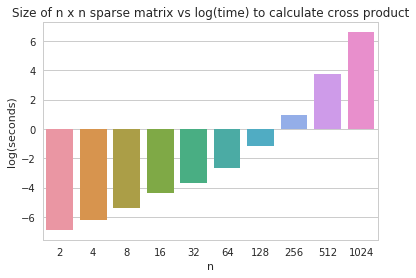

In [127]:
#Create appropiate log figure
sns.set(style="whitegrid")
ax = sns.barplot(x=df['n'], y=df['log(seconds)'], data=df).set_title('Size of n x n sparse matrix vs log(time) to calculate cross product')
ax.figure.savefig(fig_prefix + "log_seconds_for_completion")

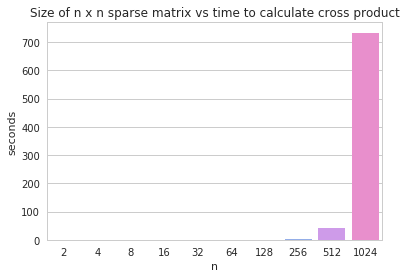

In [128]:
#Create appropiate figure
sns.set(style="whitegrid")
ax = sns.barplot(x=df['n'], y=df['seconds'], data=df).set_title('Size of n x n sparse matrix vs time to calculate cross product')
ax.figure.savefig(fig_prefix + "seconds_for_completion")